In [1]:
import sys, os
import pandas as pd

sys.path.append(os.path.abspath(os.path.join('.', '..')))
sys.path.append(os.path.abspath(os.path.join('.', 'utils')))

# import utils.str_manip as str_manip
# import utils.feature_builder as feature_builder
import utils.cluster as cluster

## Load the original data and extract features

In [2]:
# load existing clusters
orig_df = pd.read_csv('../data/original_clusters.csv')
# keep only first 2 columns
orig_df = orig_df[['Title', 'Cluster']]

### We can use other classes to perform low-level functionality directly (for testing purposes, etc.), but the Cluster class is already subclassed.

In [3]:
# sm = str_manip.StrManip()
# fb = feature_builder.FeatureBuilder()
cl = cluster.Cluster()

In [4]:
# pass in the raw data to get out features
feats = cl.get_features(orig_df['Title'])

## Create the processing pipeline
### Configurations for all possible combinations of the processing pipeline
The kwargs for clustering algorithms are algorithm specific.
Outer arguments are used for "global" variables and pipeline building:
- scaler: choose which scaling factor to use, or None
- dim_reduce: choose which dimensionality reduction algorithm to use, or None
- clusterer: choose which clustering algorithm to use.
- n_clusters: the number of clusters to aim for during clustering

In [5]:
cluster_config = {
    "kmeans_kwargs": {
        "init": "k-means++",
        "n_init": 50,
        "max_iter": 500,
        "random_state": 2901,
    },
    "hdbscan_kwargs": {
        'min_cluster_size': 15,
        'min_samples': 10,
        'metric': 'euclidean',
    },
    "agglom_kwargs": {
        'metric': 'euclidean',
        'linkage': 'ward',
    },
    "cluster": "kmeans", # kmeans, hdbscan, agglom
    "scaler": "minmax", # std, minmax
    "dim_reduce": "pca", # pca, umap
    "n_clusters": 5,
}

### See how the data is grouped after dimensionality reduction

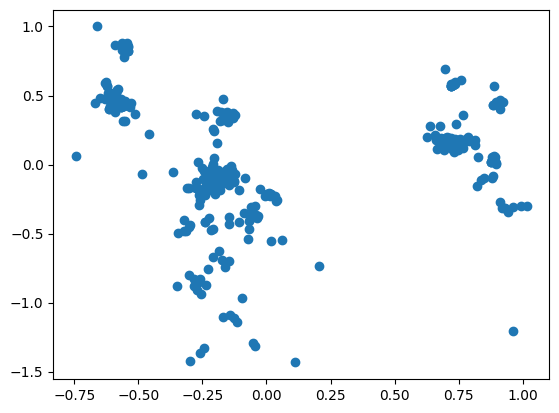

In [6]:
dim_red = cluster.Cluster()
cluster_config['dim_reduce'] = 'pca'
pipe = dim_red.setup_pipeline(**cluster_config)
pipe.fit(feats)
df = dim_red.run_pipeline(pipe, feats, orig_df['Cluster'])
dim_red.show_simple_scatterplot(df)

The above graph shows that PCA has grouped data into dense clusters of varying shapes. HDBSCAN would be a good candidate clustering algorithm for this dimensionality reduction.

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


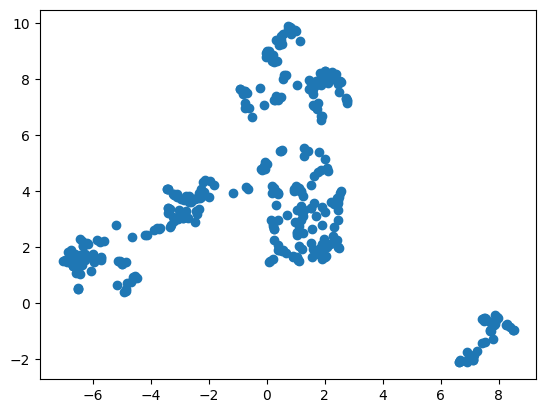

In [7]:
dim_red = cluster.Cluster()
cluster_config['dim_reduce'] = 'umap'
pipe = dim_red.setup_pipeline(**cluster_config)
pipe.fit(feats)
df = dim_red.run_pipeline(pipe, feats, orig_df['Cluster'])
dim_red.show_simple_scatterplot(df)

The above graph shows that UMAP has grouped data into more convex-looking clusters. k-means would be a good candidate clustering algorithm for this dimensionality reduction.

### Run grid search to find the best values

Running for k-means...

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


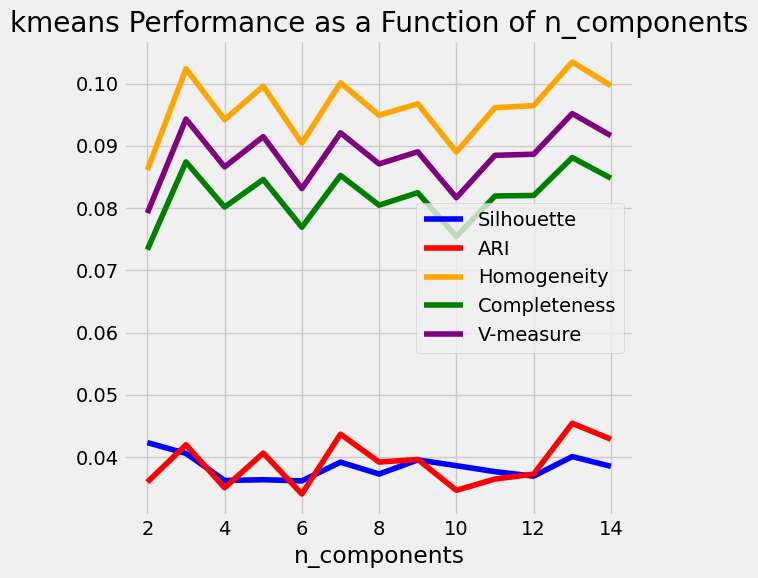

Elbow clusters computed by KneeLocator: 3


In [8]:
cluster_config['cluster'] = 'kmeans'
cluster_config['dim_reduce'] = 'umap'
cl.find_best_n_components(feats, orig_df['Cluster'], cluster_config)

Looks like the best value for n_components could be 7.

Running for HDBSCAN...

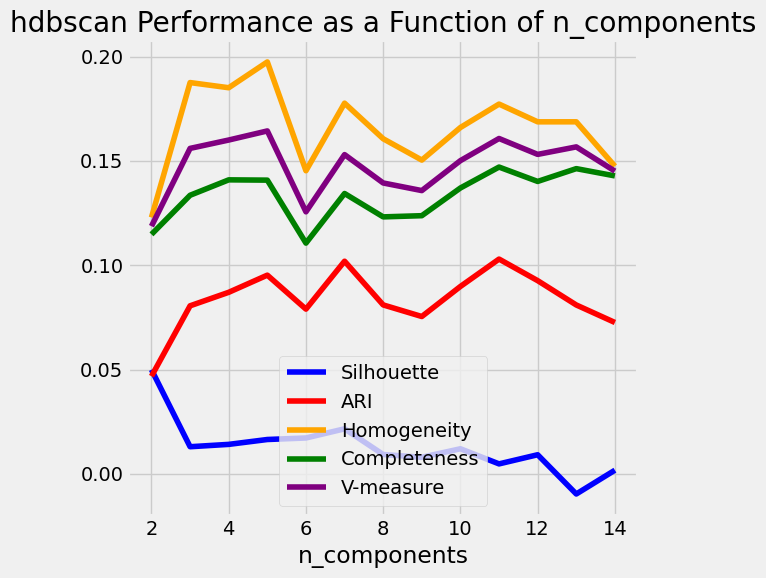

In [9]:
cluster_config['cluster'] = 'hdbscan'
cluster_config['dim_reduce'] = 'pca'
cl.find_best_n_components(feats, orig_df['Cluster'], cluster_config)

Looks like the best value for n_components is 5.

### Choose a clustering algorithm and set up the pipeline

In [10]:
# reset some variables
cl.n_components = 2
cl.component_columns = ['component_1', 'component_2']

We start with k-means + UMAP.

In [11]:
cluster_config['cluster'] = 'kmeans'
cluster_config['dim_reduce'] = 'umap'
cluster_config['n_clusters'] = 7
pipe = cl.setup_pipeline(**cluster_config)
pipe["dim_reducer"][cluster_config['dim_reduce']].n_components = 2

pipe.fit(feats)

df = cl.run_pipeline(pipe, feats, orig_df['Cluster'])

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Use the best values to create clusters

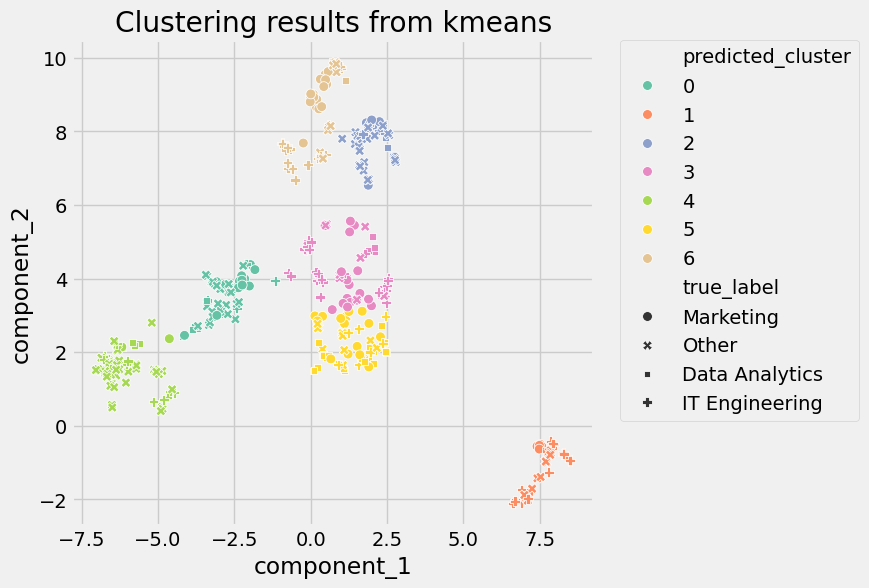

In [12]:
cl.show_scatterplot(df)

Now we do the same for HDBSCAN + PCA.

In [13]:
cluster_config['cluster'] = 'hdbscan'
cluster_config['dim_reduce'] = 'pca'
cluster_config['n_clusters'] = 5
pipe = cl.setup_pipeline(**cluster_config)
pipe["dim_reducer"][cluster_config['dim_reduce']].n_components = 2

pipe.fit(feats)

df = cl.run_pipeline(pipe, feats, orig_df['Cluster'])

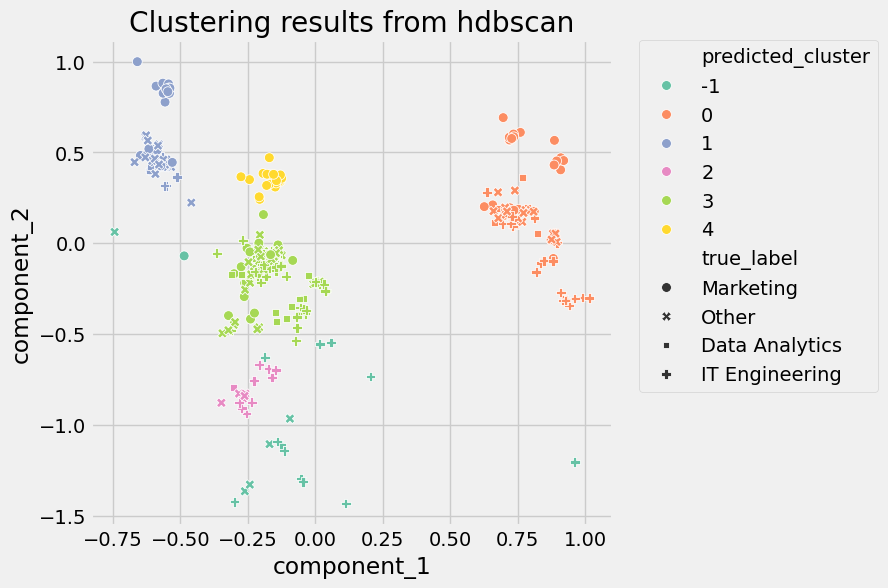

In [14]:
cl.show_scatterplot(df)

## Analyze the clusters

In [15]:
# analyze predicted groups
mask = df[df['predicted_cluster']==3].reset_index()['index']
# orig_df.loc[mask]

Extracting tf-idf features for NMF...
done in 0.005s.
Extracting tf features for LDA...
done in 0.002s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=399 and n_features=329...
done in 0.015s.


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


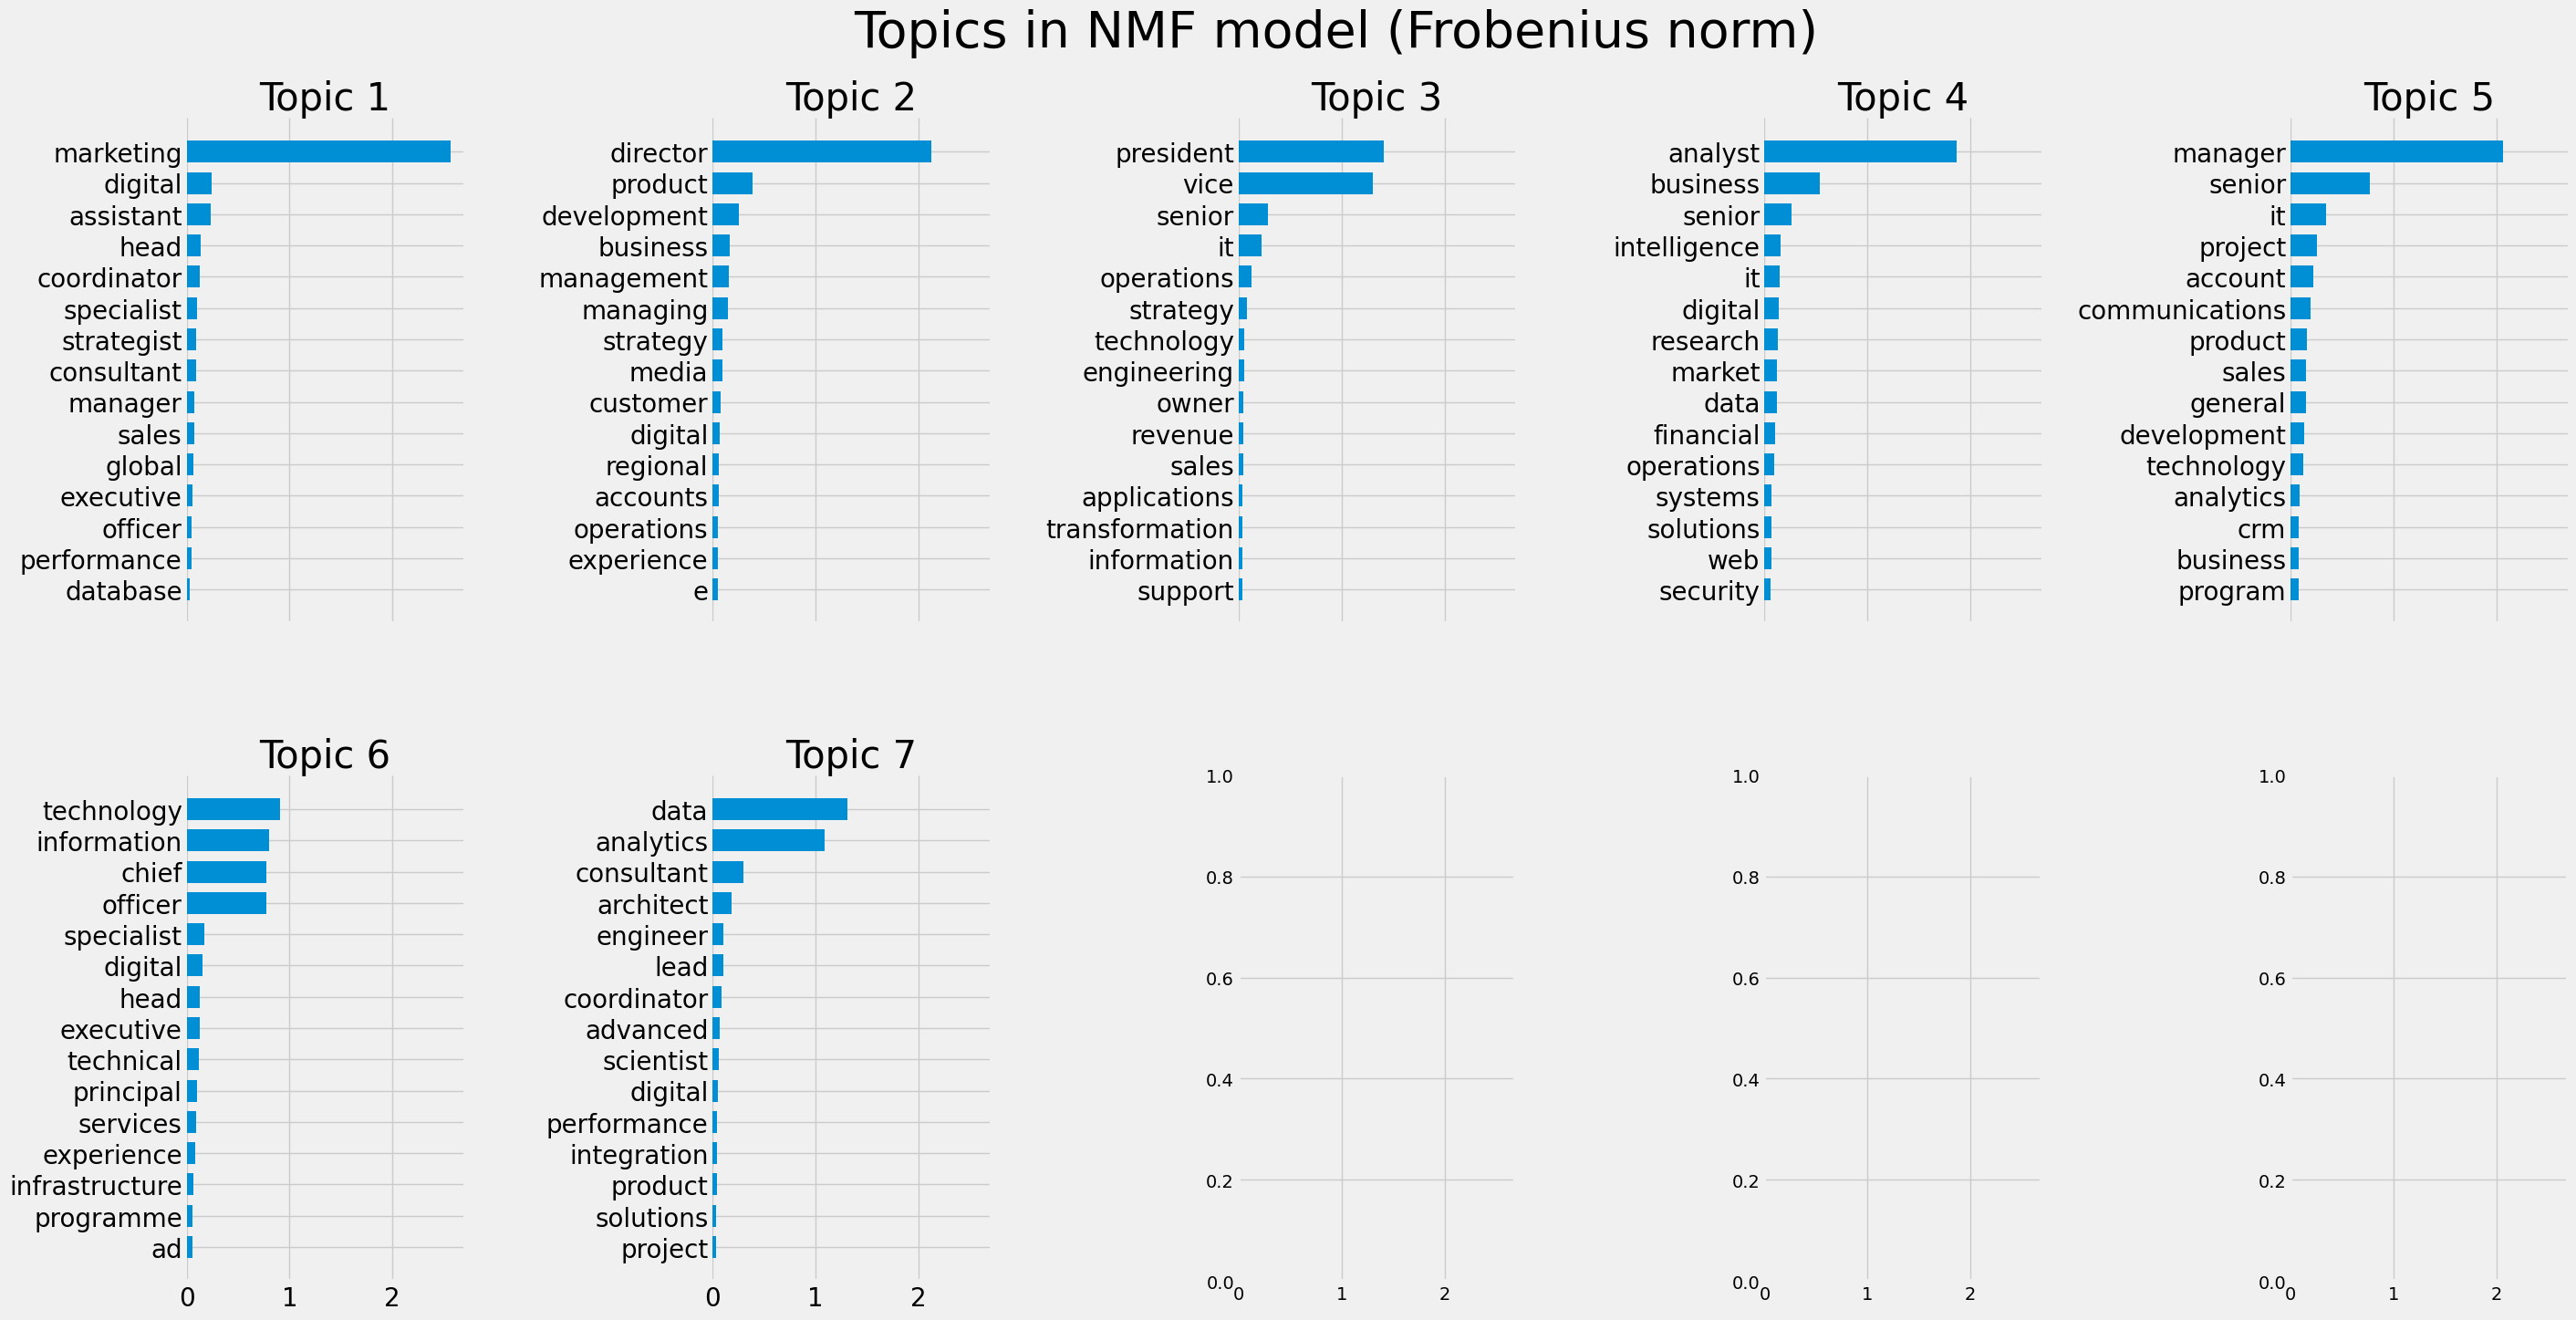



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=399 and n_features=329...
done in 0.035s.


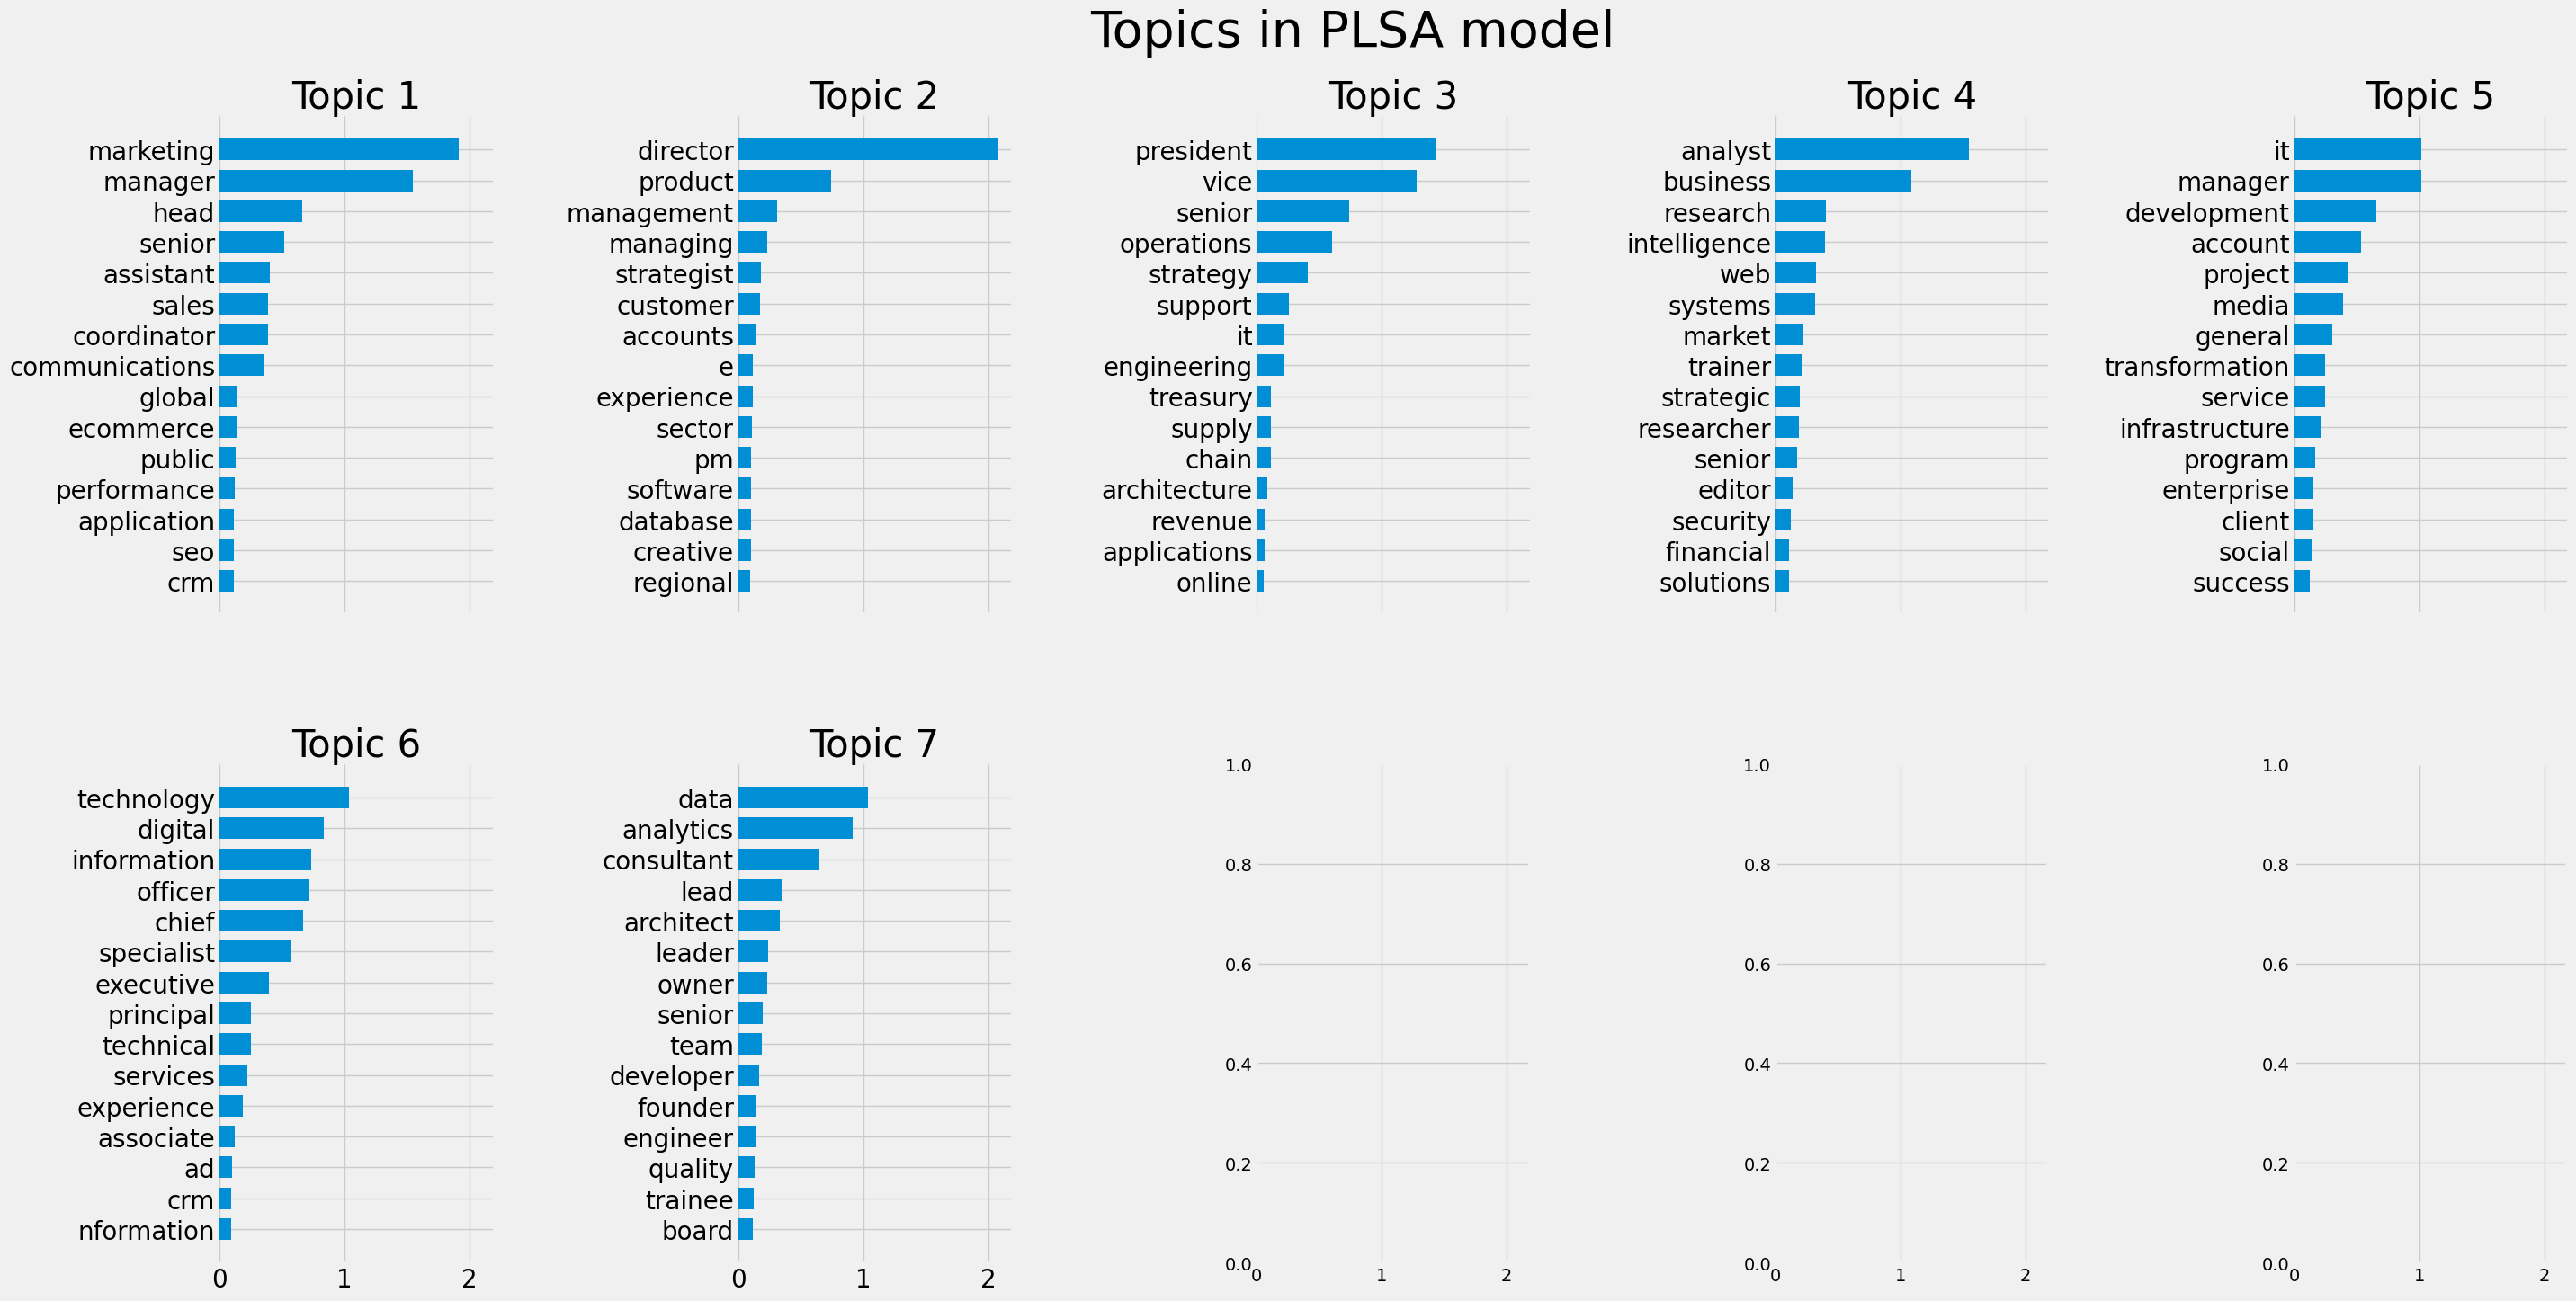



 Fitting LDA models with tf features, n_samples=399 and n_features=329...
done in 0.091s.


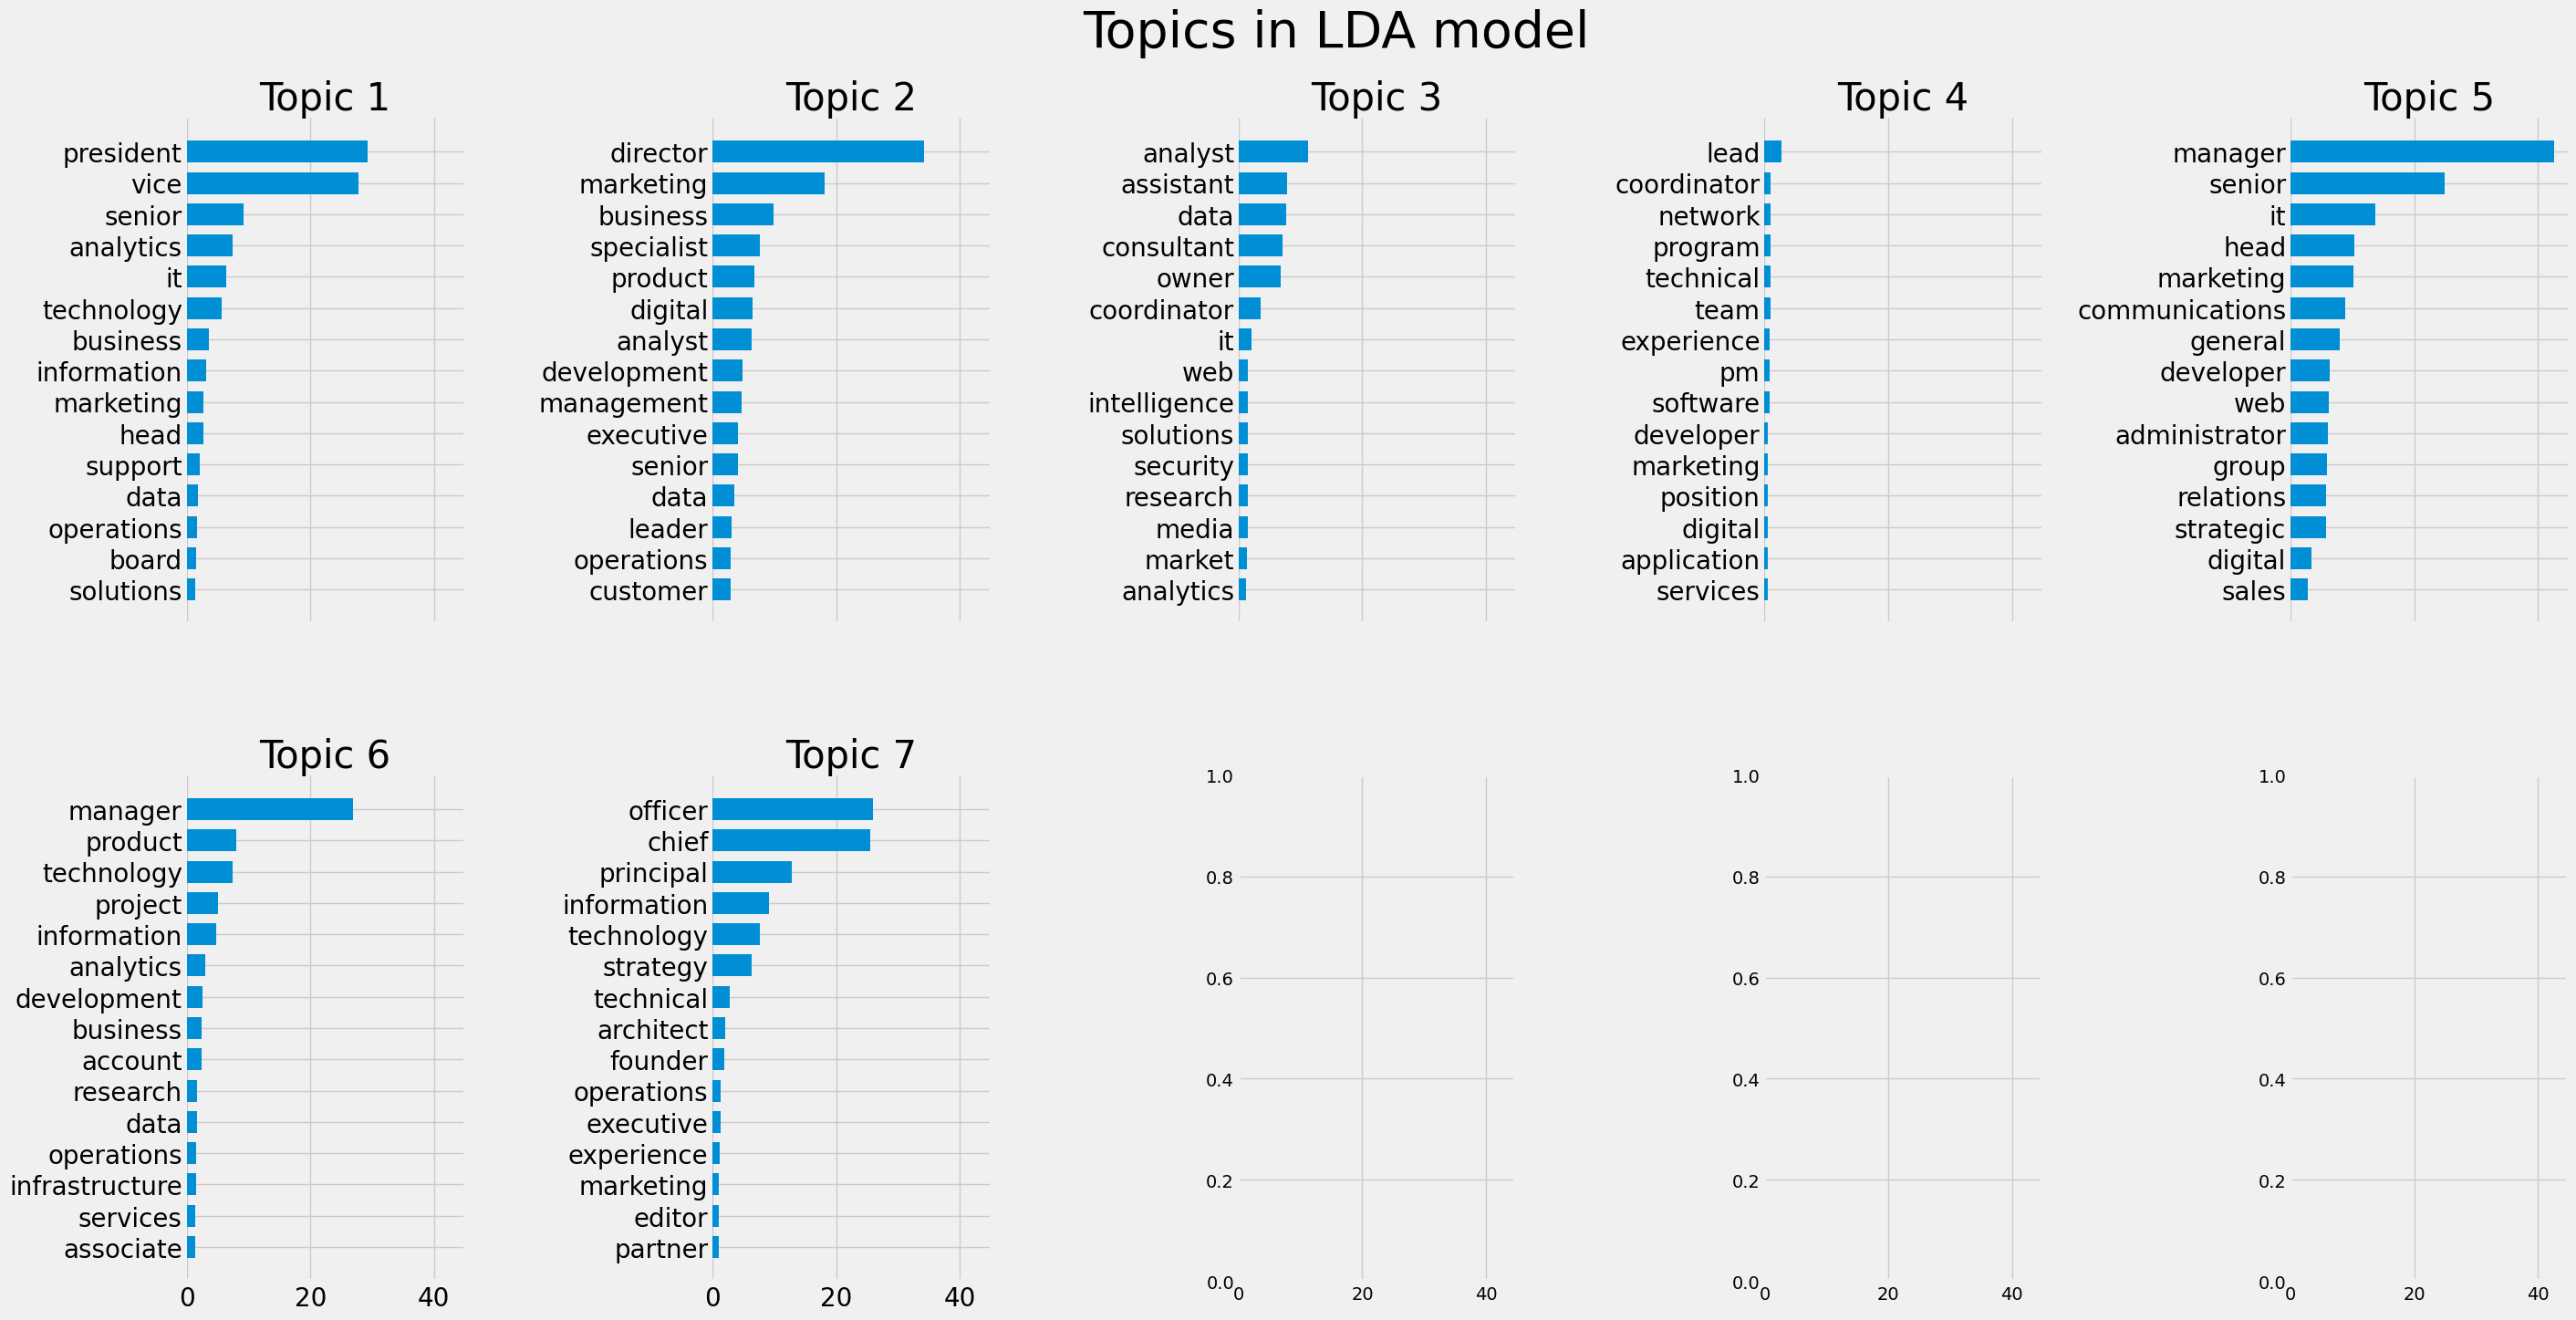

In [16]:
cl.topic_analysis(orig_df['Title'], feats, 7, n_top_words=15)